# Hydrogen Example

## Setup

In [38]:
import bw2data as bd
from datetime import datetime
bd.projects.set_current("timex")
bd.databases

Databases dictionary with 8 object(s):
	Mobility example
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei310_IMAGE_SSP2_RCP19_2020_electricity
	ei310_IMAGE_SSP2_RCP19_2030_electricity
	ei310_IMAGE_SSP2_RCP19_2040_electricity
	foreground
	test_small

In [39]:
db_bio = bd.Database("ecoinvent-3.10-biosphere") 

# Create a dict of databases keyed by year
dbs = {
    2020: bd.Database("ei310_IMAGE_SSP2_RCP19_2020_electricity"),
    # 2030: bd.Database("ei310-SSP2-RCP19-2030"),
    2030: bd.Database("ei310_IMAGE_SSP2_RCP19_2030_electricity"),
    2040: bd.Database("ei310_IMAGE_SSP2_RCP19_2040_electricity"),
}

# Add representative_time metadata for each database
for year, db in dbs.items():
    db.metadata["representative_time"] = datetime(year, 1, 1).isoformat()

eidb = bd.Database("ecoinvent-3.10-cutoff")
db_2020 =dbs[2020]

if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.write({})
foreground.register()

In [40]:
from collections import namedtuple
import numpy as np
import bw_temporalis as bwt

# === Define reusable structure for flow data ===
Flow = namedtuple("Flow", ["dataset", "amount", "type", "phase"])

# === Phase durations ===
timing_config = {
    "PEM_Electrolysis": {
        "construction": 2,
        "lifetime": 10,
        "decommissioning": 1,
    },
    "SMR": {
        "construction": 3,
        "lifetime": 10,
        "decommissioning": 2,
    }
}

# === Temporal distribution generators ===
def make_temporal_distributions(name):
    config = timing_config[name]
    c, l, d = config["construction"], config["lifetime"], config["decommissioning"]

    return {
        "pre_operation": lambda: bwt.easy_timedelta_distribution(
            start=0, end=c, resolution="Y", steps=c + 1,
            kind="triangular" if name == "SMR" else "uniform"
        ),
        "operation": lambda: bwt.easy_timedelta_distribution(
            start=c, end=c + l, resolution="Y", steps=l + 1, kind="uniform"
        ),
        "post_operation": lambda: bwt.TemporalDistribution(
            date=np.array([c + l + d], dtype="timedelta64[Y]"),
            amount=np.array([1])
        )
    }

temporal_distributions = {
    name: make_temporal_distributions(name)
    for name in timing_config
}

In [41]:
# === Important flows for PEM and SMR ===
important_flows_pem = {
    "h2_pem": Flow(db_2020.get(name="hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity", unit="kilogram"), 1.0, "production", "operation"),
    "electrolyzer_stack": Flow(db_2020.get(name="electrolyzer production, 1MWe, PEM, Stack"), 1.35e-6, "technosphere", "pre_operation"),
    "electrolyzer_bop": Flow(db_2020.get(name="electrolyzer production, 1MWe, PEM, Balance of Plant"), 3.37e-7, "technosphere", "pre_operation"),
    "electrolyzer_disposal_stack": Flow(db_2020.get(name="treatment of fuel cell stack, 1MWe, PEM"), -1.35e-6, "technosphere", "post_operation"),
    "electrolyzer_disposal_bop": Flow(db_2020.get(name="treatment of fuel cell balance of plant, 1MWe, PEM"), -3.37e-7, "technosphere", "post_operation"),
    "electricity": Flow(db_2020.get(name="market group for electricity, low voltage", location="WEU"), 54.0, "technosphere", "operation"),
    "water_deionised_europe": Flow(db_2020.get(name="market for water, deionised", location="Europe without Switzerland"), 14.0, "technosphere", "operation"),
    "oxygen_air": Flow(db_bio.get(name="Oxygen", categories=("air",)), 8.0, "biosphere", "operation"),
}

important_flows_smr = {
    "h2_smr": Flow(db_2020.get(name="hydrogen production, steam methane reforming", location="RER", unit="kilogram"), 1.0, "production", "operation"),
    "natural_gas_ch": Flow(db_2020.get(name="market for natural gas, high pressure", location="CH"), 0.0294, "technosphere", "operation"),
    "natural_gas_europe": Flow(db_2020.get(name="market group for natural gas, high pressure", location="Europe without Switzerland"), 4.22, "technosphere", "operation"),
    "chemical_factory_construction": Flow(db_2020.get(name="chemical factory construction, organics", location="RER"), 4.99e-10, "technosphere", "pre_operation"),
    "water_deionised_ch": Flow(db_2020.get(name="market for water, deionised", location="CH"), 0.0148, "technosphere", "operation"),
    "water_deionised_europe": Flow(db_2020.get(name="market for water, deionised", location="Europe without Switzerland"), 4.12, "technosphere", "operation"),
    "oxygen_air": Flow(db_bio.get(name="Oxygen", categories=("natural resource", "in air")), 6.07, "biosphere", "operation"),
    "cooling_water": Flow(db_bio.get(name="Water, cooling, unspecified natural origin", categories=("natural resource", "in water")), 0.355, "biosphere", "operation"),
    "co2_fossil": Flow(db_bio.get(name="Carbon dioxide, fossil", categories=("air",)), 8.35, "biosphere", "operation"),
}

In [42]:
# dirty fix, make sure codes match across databases

nodes = [n for d in (important_flows_pem, important_flows_smr) for n, *_ in d.values()]

for node in nodes:
    if node["database"] == db_bio.name:
        continue
    for db in dbs.values():
        node_in_other_db = db.get(
            name=node["name"],
            product=node["reference product"],
            location=node["location"],
        )
        if node["code"] != node_in_other_db["code"]:
            node_in_other_db["code"] = node["code"]
            node_in_other_db.save()

In [43]:
# === Exchange generation function ===
def flow_dict_to_exchanges(flow_dict, process_type, activity_key):
    exchanges = []
    td = temporal_distributions[process_type]

    for _, flow in flow_dict.items():
        exchange = {
            "amount": flow.amount,
            "type": flow.type,
            "input": activity_key if flow.type == "production" else flow.dataset.key,
            "unit": flow.dataset["unit"],
            "temporal_distribution": td[flow.phase](),
            "operation": flow.phase == "operation",
        }
        exchanges.append(exchange)

    return exchanges

# === Define foreground activities ===
pem_key = ("foreground", "hydrogen_production_pem")
smr_key = ("foreground", "hydrogen_production_smr")

pem_activity = {
    pem_key: {
        "name": "Hydrogen via PEM electrolysis",
        "unit": "kilogram",
        "location": "RER",
        "reference product": "hydrogen",
        "exchanges": flow_dict_to_exchanges(important_flows_pem, "PEM_Electrolysis", pem_key),
        "operation_time_limits": (2,2+10),
    }
}

smr_activity = {
    smr_key: {
        "name": "Hydrogen via Steam Methane Reforming",
        "unit": "kilogram",
        "location": "RER",
        "reference product": "hydrogen",
        "exchanges": flow_dict_to_exchanges(important_flows_smr, "SMR", smr_key),
        "operation_time_limits": (3,3+10),
    }
}

# === Write to foreground database ===
foreground.write({**pem_activity, **smr_activity})
foreground.register()


09:30:04+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 6350.20it/s]

09:30:04+0200 [info     ] Vacuuming database            


In [44]:
from datetime import datetime
method = ('EF v3.1 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT')

# Define temporally distributed demand from 2025 to 2045
years = range(2025, 2040)
td_demand = bwt.TemporalDistribution(
    date=np.array([datetime(year, 1, 1).isoformat() for year in years], dtype='datetime64[s]'),
    amount=np.asarray([10000] * len(years), dtype=float)  # 100 kg per year
)

## Optimization

In [109]:
import pandas as pd
import pyomo.environ as pyo 
from dynamic_characterization import characterize

def get_radiative_forcing(m, fixed_time_horizon=False):
    
    
    fg_scale = getattr(m, "scales", {}).get("foreground", 1.0)
    inventory = {
        (p, e, t): pyo.value(m.scaled_inventory[p, e, t]) * fg_scale
        for p in m.PROCESS
        for e in m.ELEMENTARY_FLOW
        for t in m.SYSTEM_TIME
    }


    dynamic_inventory_df = (
        pd.DataFrame.from_records(
            [(p, e, t, v) for (p, e, t), v in inventory.items()],
            columns=["activity", "flow", "date", "amount"]
        )
        .astype({
            "activity": "string",
            "flow": "string",
            "amount": "float64"
        })
    )

    dynamic_inventory_df["date"] = pd.to_datetime(dynamic_inventory_df["date"], format="%Y")
    

    dynamic_inventory_df["flow"] = dynamic_inventory_df["flow"].apply(
        lambda x: db_bio.get(code=x).id
    )

    return characterize(
            dynamic_inventory_df,
            metric="radiative_forcing", # could also be GWP
            base_lcia_method=method,
            time_horizon=100,
            fixed_time_horizon=fixed_time_horizon,
    )

In [ ]:
def get_radiative_forcing_all_emissions_at_2025(m, fixed_time_horizon=False):
    
    
    fg_scale = getattr(m, "scales", {}).get("foreground", 1.0)
    inventory = {
        (p, e, t): pyo.value(m.scaled_inventory[p, e, t]) * fg_scale
        for p in m.PROCESS
        for e in m.ELEMENTARY_FLOW
        for t in m.SYSTEM_TIME
    }


    dynamic_inventory_df = (
        pd.DataFrame.from_records(
            [(p, e, t, v) for (p, e, t), v in inventory.items()],
            columns=["activity", "flow", "date", "amount"]
        )
        .astype({
            "activity": "string",
            "flow": "string",
            "amount": "float64"
        })
    )

    dynamic_inventory_df["date"] = pd.to_datetime(dynamic_inventory_df["date"], format="%Y")
    
    dynamic_inventory_df["date"] = pd.to_datetime("2025-01-01")
    
    dynamic_inventory_df["flow"] = dynamic_inventory_df["flow"].apply(
        lambda x: db_bio.get(code=x).id
    )

    return characterize(
            dynamic_inventory_df,
            metric="radiative_forcing", # could also be GWP
            base_lcia_method=method,
            time_horizon=100,
            fixed_time_horizon=fixed_time_horizon,
    )

In [ ]:
from optimex import lca_processor, converter, optimizer, postprocessing

lca_config_no_evolution = lca_processor.LCAConfig(
    demand={"hydrogen": td_demand},
    temporal={
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
        "database_dates": {
            "ei310_IMAGE_SSP2_RCP19_2020_electricity": datetime(2020, 1, 1),
        },
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method,
            "metric": "CRF", # CRF
        },
        {
            "category_name": "resource_depletion",
            "brightway_method": (
                "EF v3.1 no LT",
                "material resources: metals/minerals no LT",
                "abiotic depletion potential (ADP): elements (ultimate reserves) no LT",
            ),
        },
    ],
)

lca_data_processor_no_evolution = lca_processor.LCADataProcessor(lca_config_no_evolution)

manager_no_evolution = converter.ModelInputManager()
optimization_model_inputs = manager_no_evolution.parse_from_lca_processor(lca_data_processor_no_evolution) 

model_no_evolution = optimizer.create_model(
    optimization_model_inputs_no_evolution,
    name = "demo_simple_example",
    objective_category = "climate_change",
    flexible_operation = True, # Feel free to change this to see both
)

m_no_evolution, obj, results = optimizer.solve_model(model_no_evolution, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-06-16 09:31:08.023 | INFO     | optimex.lca_processor:_parse_demand:332 - Identified demand in system time range of %s for functional flows %s
2025-06-16 09:31:08.037 | INFO     | optimex.lca_processor:_construct_foreground_tensors:457 - Constructed foreground tensors.
2025-06-16 09:31:08.038 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Technosphere shape: (2 processes, 10 flows, 14 years) with 78 total entries.
2025-06-16 09:31:08.038 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Biosphere shape: (2 processes, 4 flows, 12 years) with 44 total entries.
2025-06-16 09:31:08.038 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Production shape: (2 processes, 1 flows, 12 years) with 22 total entries.
2025-06-16 09:31:08.039 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:495 - Calculating inventory for database: ei310_IMAGE_SSP2_RCP19_2020_electricity
/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/s

2025-06-16 09:34:16.131 | INFO     | optimex.optimizer:create_model:67 - Creating sets
2025-06-16 09:34:16.139 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-06-16 09:34:16.194 | INFO     | optimex.optimizer:create_model:272 - Creating variables
2025-06-16 09:34:20.026 | INFO     | optimex.optimizer:solve_model:601 - Solver [glpk] termination: optimal
2025-06-16 09:34:22.856 | INFO     | optimex.optimizer:solve_model:626 - Objective (scaled): 105.067
2025-06-16 09:34:22.857 | INFO     | optimex.optimizer:solve_model:627 - Objective (real):   1.20425e-08


In [59]:
from optimex import lca_processor, converter, optimizer, postprocessing

lca_config = lca_processor.LCAConfig(
    demand={"hydrogen": td_demand},
    temporal={
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
        "database_dates": {
            "ei310_IMAGE_SSP2_RCP19_2020_electricity": datetime(2020, 1, 1),
            "ei310_IMAGE_SSP2_RCP19_2030_electricity": datetime(2030, 1, 1),
            "ei310_IMAGE_SSP2_RCP19_2040_electricity": datetime(2040, 1, 1),
        },
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method,
            "metric": "CRF", # CRF
        },
        {
            "category_name": "resource_depletion",
            "brightway_method": (
                "EF v3.1 no LT",
                "material resources: metals/minerals no LT",
                "abiotic depletion potential (ADP): elements (ultimate reserves) no LT",
            ),
        },
    ],
)

lca_data_processor = lca_processor.LCADataProcessor(lca_config)

manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change",
    flexible_operation = True, # Feel free to change this to see both
)

m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-06-16 09:37:17.961 | INFO     | optimex.lca_processor:_parse_demand:332 - Identified demand in system time range of %s for functional flows %s
2025-06-16 09:37:17.986 | INFO     | optimex.lca_processor:_construct_foreground_tensors:457 - Constructed foreground tensors.
2025-06-16 09:37:17.986 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Technosphere shape: (2 processes, 10 flows, 14 years) with 78 total entries.
2025-06-16 09:37:17.986 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Biosphere shape: (2 processes, 4 flows, 12 years) with 44 total entries.
2025-06-16 09:37:17.986 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Production shape: (2 processes, 1 flows, 12 years) with 22 total entries.
2025-06-16 09:37:17.987 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:495 - Calculating inventory for database: ei310_IMAGE_SSP2_RCP19_2020_electricity
/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/s

In [ ]:
from optimex import lca_processor, converter, optimizer, postprocessing

lca_config_limited_resources = lca_processor.LCAConfig(
    demand={"hydrogen": td_demand},
    temporal={
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
        "database_dates": {
            "ei310_IMAGE_SSP2_RCP19_2020_electricity": datetime(2020, 1, 1),
            "ei310_IMAGE_SSP2_RCP19_2030_electricity": datetime(2030, 1, 1),
            "ei310_IMAGE_SSP2_RCP19_2040_electricity": datetime(2040, 1, 1),
        },
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method,
            "metric": "CRF", # CRF
        },
        {
            "category_name": "resource_depletion",
            "brightway_method": (
                "EF v3.1 no LT",
                "material resources: metals/minerals no LT",
                "abiotic depletion potential (ADP): elements (ultimate reserves) no LT",
            ),
        },
    ],
)

lca_data_processor_limited_resources = lca_processor.LCADataProcessor(lca_config)

manager_limited_resources = converter.ModelInputManager()
optimization_model_inputs_limited_resources = manager.parse_from_lca_processor(lca_data_processor) 

optimization_model_inputs_limited_resources.category_impact_limit = {
    "resource_depletion": 1,
}

model_limited_resources = optimizer.create_model(
    optimization_model_inputs_limited_resources,
    name = "demo_simple_example",
    objective_category = "climate_change",
    flexible_operation = True, # Feel free to change this to see both
)

m_limited_resources, obj, results = optimizer.solve_model(model_limited_resources, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-06-16 11:16:47.772 | INFO     | optimex.lca_processor:_parse_demand:332 - Identified demand in system time range of %s for functional flows %s
2025-06-16 11:16:47.798 | INFO     | optimex.lca_processor:_construct_foreground_tensors:457 - Constructed foreground tensors.
2025-06-16 11:16:47.799 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Technosphere shape: (2 processes, 10 flows, 14 years) with 78 total entries.
2025-06-16 11:16:47.799 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Biosphere shape: (2 processes, 4 flows, 12 years) with 44 total entries.
2025-06-16 11:16:47.800 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Production shape: (2 processes, 1 flows, 12 years) with 22 total entries.
2025-06-16 11:16:47.800 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:495 - Calculating inventory for database: ei310_IMAGE_SSP2_RCP19_2020_electricity
/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/s

In [230]:
optimization_model_inputs_limited_resources.category_impact_limit = {
    "resource_depletion": 0.1,
}

model_limited_resources = optimizer.create_model(
    optimization_model_inputs_limited_resources,
    name = "demo_simple_example",
    objective_category = "climate_change",
    flexible_operation = True, # Feel free to change this to see both
)

m_limited_resources, obj, results = optimizer.solve_model(model_limited_resources, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-06-16 11:27:29.289 | INFO     | optimex.optimizer:create_model:67 - Creating sets
2025-06-16 11:27:29.290 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-06-16 11:27:29.359 | INFO     | optimex.optimizer:create_model:272 - Creating variables
2025-06-16 11:27:33.813 | INFO     | optimex.optimizer:solve_model:601 - Solver [glpk] termination: optimal
2025-06-16 11:27:36.750 | INFO     | optimex.optimizer:solve_model:626 - Objective (scaled): 1.70076
2025-06-16 11:27:36.751 | INFO     | optimex.optimizer:solve_model:627 - Objective (real):   1.03245e-08


In [ ]:
rf = get_radiative_forcing(m)
rf_limited_resources = get_radiative_forcing(m_limited_resources)
rf_no_evolution = get_radiative_forcing(m_no_evolution)
rf_all_at_2025 = get_radiative_forcing_all_emissions_at_2025(m_no_evolution)

2025-06-16 11:29:20.461 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


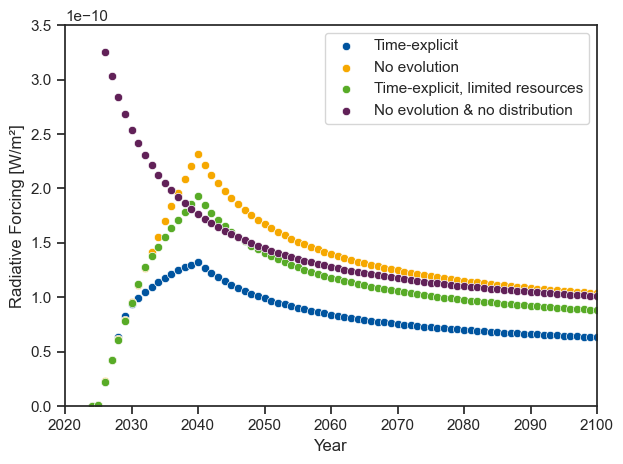

In [341]:
import seaborn as sns

# Time explicit
rf["date_rounded"] = (
    (rf["date"] + pd.DateOffset(months=6)).dt.to_period("Y").dt.start_time
)
rf_grouped = rf.groupby(["date_rounded"], as_index=False)["amount"].sum()
rf_grouped = rf_grouped[rf_grouped["date_rounded"].dt.year <= 2100]

# No Evolution
rf_no_evolution["date_rounded"] = (
    (rf_no_evolution["date"] + pd.DateOffset(months=6)).dt.to_period("Y").dt.start_time
)
rf_no_evolution_grouped = rf_no_evolution.groupby(["date_rounded"], as_index=False)[
    "amount"
].sum()
rf_no_evolution_grouped = rf_no_evolution_grouped[
    rf_no_evolution_grouped["date_rounded"].dt.year <= 2100
]

# Limited Resources
rf_limited_resources["date_rounded"] = (
    (rf_limited_resources["date"] + pd.DateOffset(months=6)).dt.to_period("Y").dt.start_time
)
rf_limited_resources_grouped = rf_limited_resources.groupby(["date_rounded"], as_index=False)[
    "amount"
].sum()
rf_limited_resources_grouped = rf_limited_resources_grouped[
    rf_limited_resources_grouped["date_rounded"].dt.year <= 2100
]

# No Evolution & Distribution
rf_all_at_2025["date_rounded"] = (
    (rf_all_at_2025["date"] + pd.DateOffset(months=6)).dt.to_period("Y").dt.start_time
)
rf_all_at_2025_grouped = rf_all_at_2025.groupby(["date_rounded"], as_index=False)[
    "amount"
].sum()
rf_all_at_2025_grouped = rf_all_at_2025_grouped[
    rf_all_at_2025_grouped["date_rounded"].dt.year <= 2100
]

sns.scatterplot(
    data=rf_grouped,
    x="date_rounded",
    y="amount",
    label="Time-explicit",
    color="#00549F",  # blue
)

sns.scatterplot(
    data=rf_no_evolution_grouped,
    x="date_rounded",
    y="amount",
    label="No evolution",
    color="#F6A800",  # yellow-orange
)

sns.scatterplot(
    data=rf_limited_resources_grouped,
    x="date_rounded",
    y="amount",
    label="Time-explicit, limited resources",
    color="#58AB27",  # yellow-orange
)


sns.scatterplot(
    data=rf_all_at_2025_grouped,
    x="date_rounded",
    y="amount",
    label="No evolution & no distribution",
    color="#612158",  # green
)

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Ensure 2025 is included
ticks = set(ax.get_xticks())
ticks.add(mdates.date2num(pd.Timestamp("2020-01-01")))
ax.set_xticks(sorted(ticks))
ax.set_xlim(right=pd.Timestamp("2100-01-01"))

# Get current y-ticks and add 3.5
yticks = set(ax.get_yticks())
yticks.add(3.5e-10)
ax.set_yticks(sorted(yticks))
ax.set_ylim(bottom=0)

ax.set_xlabel("Year")
ax.set_ylabel("Radiative Forcing [W/m²]")
plt.tight_layout()
plt.savefig("rf.svg")

In [244]:
pp = postprocessing.PostProcessor(m)
pp_limited_resources = postprocessing.PostProcessor(m_limited_resources)
pp_no_evolution = postprocessing.PostProcessor(m_no_evolution)

In [260]:
installation_limited_resources = pp_limited_resources.get_installation()
production_limited_resources = pp_limited_resources.get_production()

installation = pp.get_installation()
production = pp.get_production()

installation_no_evolution = pp_no_evolution.get_installation()
production_no_evolution = pp_no_evolution.get_production()

/var/folders/l1/k90rhb0j0ns58y35ymznsd700000gn/T/ipykernel_34429/1501765527.py:59: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df.drop(columns='scenario')
/var/folders/l1/k90rhb0j0ns58y35ymznsd700000gn/T/ipykernel_34429/1501765527.py:62: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(columns='scenario').plot(


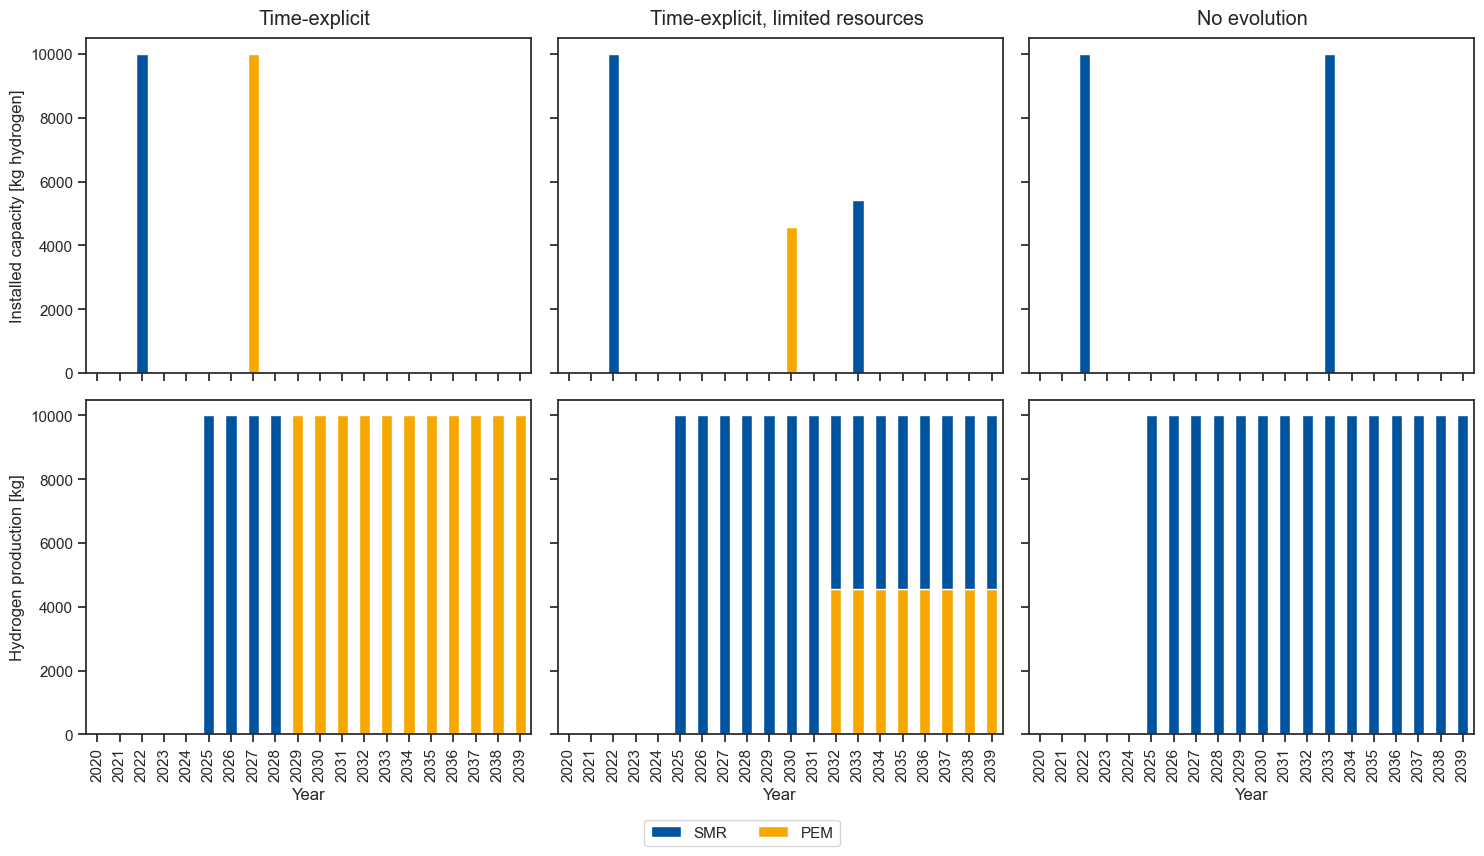

In [340]:
import pandas as pd
import matplotlib.pyplot as plt

# Add scenario labels
installation_limited_resources['scenario'] = 'limited_resources'
installation['scenario'] = 'default'
installation_no_evolution['scenario'] = 'no_evolution'

production_limited_resources['scenario'] = 'limited_resources'
production['scenario'] = 'default'
production_no_evolution['scenario'] = 'no_evolution'

# Pretty names
titles = {
    'default': 'Time-explicit',
    'limited_resources': 'Time-explicit, limited resources',
    'no_evolution': 'No evolution',
}

# Organize
installations = {
    'default': installation,
    'limited_resources': installation_limited_resources,
    'no_evolution': installation_no_evolution,
}

productions = {
    'default': production,
    'limited_resources': production_limited_resources,
    'no_evolution': production_no_evolution,
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey='row', sharex=True)


tech_colors = {"hydrogen_production_smr": "#00549F",
          "hydrogen_production_pem": "#F6A800"}

# Plot installations (top row) — no legends here
for i, (scenario, df) in enumerate(installations.items()):
    df2 = df.drop(columns='scenario')
    techs = [c[0] if isinstance(c, tuple) else c for c in df2.columns]
    colors = [tech_colors[t] for t in techs]
    plot = df.drop(columns='scenario').plot(
        ax=axes[0, i], kind='bar', stacked=True, legend=False, color=colors
    )
    axes[0, i].set_xlabel("")
    if i == 0:
        axes[0, i].set_ylabel("Installed capacity [kg hydrogen]")

    # Save handles from the first plot
    if legend_handles is None:
        handles, labels = plot.get_legend_handles_labels()
        if handles:
            legend_handles, legend_labels = handles, labels

# Plot productions (bottom row)
for i, (scenario, df) in enumerate(productions.items()):
    df2 = df.drop(columns='scenario')
    techs = [c[0] if isinstance(c, tuple) else c for c in df2.columns]
    colors = [tech_colors[t] for t in techs]
    df.drop(columns='scenario').plot(
        ax=axes[1, i], kind='bar', stacked=True, legend=False, color=colors
    )
    axes[1, i].set_xlabel("Year")
    if i == 0:
        axes[1, i].set_ylabel("Hydrogen production [kg]")

# explicit x positions (tweak these to line up over each subplot)
x_coords = [0.215, 0.53, 0.84]

for i, scenario in enumerate(installations.keys()):
    fig.text(
        x=x_coords[i],
        y=axes[0, i].get_position().y1 + 0.11,  # keep your original y
        s=titles[scenario],
        ha='center',
        va='bottom',
        fontsize='large',
        # weight='bold'
    )

plt.tight_layout()
plt.subplots_adjust(top=0.89)

for ax in axes.flatten():
    ax.minorticks_off()
    
# map long → short
legend_rename = {
    "hydrogen_production_pem": "PEM",
    "hydrogen_production_smr": "SMR",
}

# build your short labels
short_labels = [legend_rename.get(lbl, lbl) for lbl in legend_labels]

# then draw legend
fig.legend(
    legend_handles[::-1],
    short_labels[::-1],
    loc='upper center',
    ncol=len(short_labels),
    bbox_to_anchor=(0.5, 0.01)
)

plt.tight_layout()
plt.savefig(
    "installment_and_production.svg",
    bbox_inches="tight",
    # pad_inches=0.02  # you can tweak this
)
# plt.show()

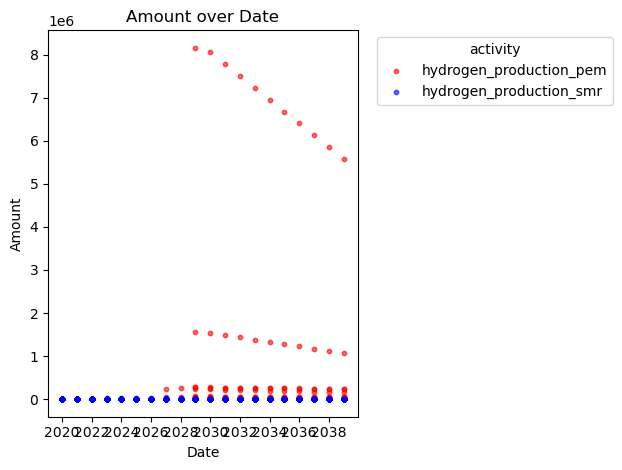

In [157]:
import matplotlib.pyplot as plt

cols = ["red", "blue"]                # first → red, second → blue
cats = dynamic_inventory_df["activity"].astype(str).unique()

fig, ax = plt.subplots()
for i, cat in enumerate(cats):
    sub = dynamic_inventory_df[dynamic_inventory_df["activity"] == cat]
    ax.scatter(sub["date"], sub["amount"],
               s=10, alpha=0.6,
               color=cols[i] if i < len(cols) else "gray",  # fallback if extra cats
               label=cat)

ax.set_xlabel("Date")
ax.set_ylabel("Amount")
ax.set_title("Amount over Date")
ax.legend(title="activity", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [12]:
rf_climate_opt_timex = get_radiative_forcing(m)

2025-06-16 09:08:37.807 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


In [13]:
from optimex import lca_processor, converter, optimizer

lca_config = lca_processor.LCAConfig(
    demand={"hydrogen": td_demand},
    temporal={
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
        "fixed_time_horizon": False, # <-- This is the key difference
        "database_dates": {
            "ei310_IMAGE_SSP2_RCP19_2020_electricity": datetime(2020, 1, 1),
            "ei310_IMAGE_SSP2_RCP19_2030_electricity": datetime(2030, 1, 1),
            "ei310_IMAGE_SSP2_RCP19_2040_electricity": datetime(2040, 1, 1),
        },
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method,
            "metric": "GWP", # CRF
        },
        {
            "category_name": "resource_depletion",
            "brightway_method": (
                "EF v3.1 no LT",
                "material resources: metals/minerals no LT",
                "abiotic depletion potential (ADP): elements (ultimate reserves) no LT",
            ),
        },
    ],
)

lca_data_processor = lca_processor.LCADataProcessor(lca_config)

manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change",
    flexible_operation = True, # Feel free to change this to see both
)

m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.x

2025-06-16 09:08:38.094 | INFO     | optimex.lca_processor:_parse_demand:332 - Identified demand in system time range of %s for functional flows %s
2025-06-16 09:08:38.103 | INFO     | optimex.lca_processor:_construct_foreground_tensors:457 - Constructed foreground tensors.
2025-06-16 09:08:38.103 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Technosphere shape: (2 processes, 10 flows, 14 years) with 78 total entries.
2025-06-16 09:08:38.103 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Biosphere shape: (2 processes, 4 flows, 12 years) with 44 total entries.
2025-06-16 09:08:38.104 | INFO     | optimex.lca_processor:log_tensor_dimensions:452 - Production shape: (2 processes, 1 flows, 12 years) with 22 total entries.
2025-06-16 09:08:38.104 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:495 - Calculating inventory for database: ei310_IMAGE_SSP2_RCP19_2020_electricity
/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/s

In [19]:
optimization_model_inputs.characterization

{('climate_change', '375bc95e-6596-4aa1-9716-80ff51b9da77', 2020): -1.0,
 ('climate_change',
  'fa5512cf-04a2-4014-8e96-d3e2d137f0df',
  2020): 0.005910004535867082,
 ('climate_change',
  '9beb60a3-3a8c-4345-9a0e-107eec2f709f',
  2020): 0.019022454929089837,
 ('climate_change',
  'e7e0031e-791d-42f4-b26c-ec322db637bc',
  2020): 0.417272390593384,
 ('climate_change', '349b29d1-3e58-4c66-98b9-9d1a076efd2e', 2020): 1.0,
 ('climate_change', '78eb1859-abd9-44c6-9ce3-f3b5b33d619c', 2020): 1.0,
 ('climate_change', 'aa7cac3a-3625-41d4-bc54-33e2cf11ec46', 2020): 1.0,
 ('climate_change', 'e4e9febc-07c1-403d-8d3a-6707bb4d96e6', 2020): 1.0,
 ('climate_change', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9', 2020): 1.0,
 ('climate_change',
  '4cadbc9f-0472-4bb9-a942-df5b90e37878',
  2020): 19.685288830373654,
 ('climate_change',
  '0795345f-c7ae-410c-ad25-1845784c75f5',
  2020): 26.705808501447027,
 ('climate_change',
  '5f7aad3d-566c-4d0d-ad59-e765f971aa0f',
  2020): 26.705808501447027,
 ('climate_change'

In [27]:
rf_climate_opt_no_tds = get_radiative_forcing(m, fixed_time_horizon=True)


2025-06-16 09:15:16.754 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


In [ ]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

pp = postprocessing.PostProcessor(m)


In [ ]:
# optimization_model_inputs.category_impact_limit = {
#     "resource_depletion": 1,
# }


In [14]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

some scaling issue is going on here, look at land use and what it was constrainted to

In [15]:
import pyomo.environ as pyo
{
            (t, p): pyo.value(model.var_installation[p, t])
            for p in model.PROCESS
            for t in model.SYSTEM_TIME
        }

{(2020, 'hydrogen_production_smr'): 0.0,
 (2021, 'hydrogen_production_smr'): 0.0,
 (2022, 'hydrogen_production_smr'): 10000.0,
 (2023, 'hydrogen_production_smr'): 0.0,
 (2024, 'hydrogen_production_smr'): 0.0,
 (2025, 'hydrogen_production_smr'): 0.0,
 (2026, 'hydrogen_production_smr'): 0.0,
 (2027, 'hydrogen_production_smr'): 0.0,
 (2028, 'hydrogen_production_smr'): 0.0,
 (2029, 'hydrogen_production_smr'): 0.0,
 (2030, 'hydrogen_production_smr'): 0.0,
 (2031, 'hydrogen_production_smr'): 0.0,
 (2032, 'hydrogen_production_smr'): 0.0,
 (2033, 'hydrogen_production_smr'): 10000.0,
 (2034, 'hydrogen_production_smr'): 0.0,
 (2035, 'hydrogen_production_smr'): 0.0,
 (2036, 'hydrogen_production_smr'): 0.0,
 (2037, 'hydrogen_production_smr'): 0.0,
 (2038, 'hydrogen_production_smr'): 0.0,
 (2039, 'hydrogen_production_smr'): 0.0,
 (2040, 'hydrogen_production_smr'): 0.0,
 (2041, 'hydrogen_production_smr'): 0.0,
 (2042, 'hydrogen_production_smr'): 0.0,
 (2043, 'hydrogen_production_smr'): 0.0,
 (2044, 

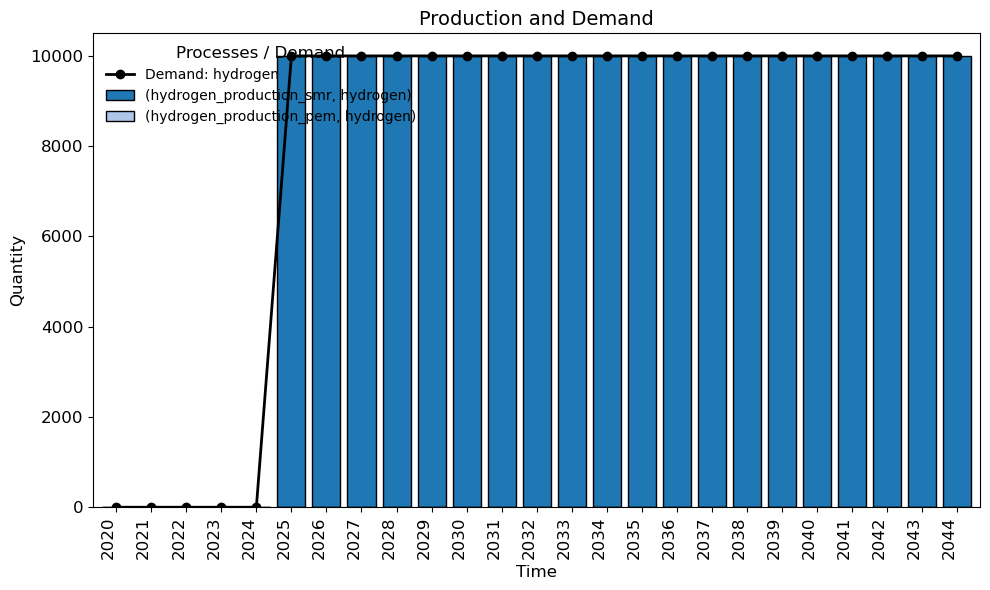

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Production and Demand'}, xlabel='Time', ylabel='Quantity'>)

In [17]:
pp.plot_production_and_demand()

In [18]:
pp.get_installation()

Process,hydrogen_production_pem,hydrogen_production_smr
Time,,
2020,0.0,0.0
2021,0.0,0.0
2022,0.0,10000.0
2023,0.0,0.0
2024,0.0,0.0
2025,0.0,0.0
2026,0.0,0.0
2027,0.0,0.0
2028,0.0,0.0


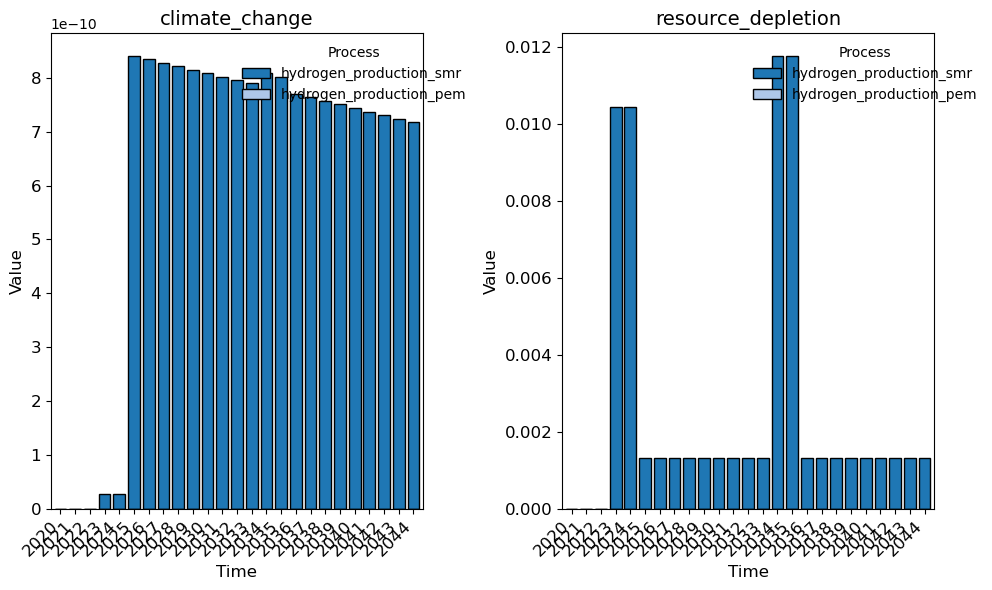

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'climate_change'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'resource_depletion'}, xlabel='Time', ylabel='Value'>],
       dtype=object))

In [19]:
pp.plot_impacts()

opt land use

In [55]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "resource_depletion",
    flexible_operation = True, # Feel free to change this to see both
)

2025-06-13 13:01:23.075 | INFO     | optimex.optimizer:create_model:67 - Creating sets


2025-06-13 13:01:23.078 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-06-13 13:01:23.149 | INFO     | optimex.optimizer:create_model:272 - Creating variables


In [56]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-06-13 13:01:28.843 | INFO     | optimex.optimizer:solve_model:601 - Solver [glpk] termination: optimal
2025-06-13 13:01:31.970 | INFO     | optimex.optimizer:solve_model:626 - Objective (scaled): 0.051816
2025-06-13 13:01:31.970 | INFO     | optimex.optimizer:solve_model:627 - Objective (real):   0.5647


In [82]:
import bw2calc as bc

In [83]:
lca = bc.LCA(
    demand={db_2020.get(name="hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity", unit="kilogram"): 10000},
    method=(
                "EF v3.1 no LT",
                "material resources: metals/minerals no LT",
                "abiotic depletion potential (ADP): elements (ultimate reserves) no LT",
            ),
)

In [84]:
lca.lci()
lca.lcia()
print("Total impact:", lca.score)

Total impact: 2.534332848350403


/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.13e+13)
  warnings.warn(msg, UmfpackWarning)


In [ ]:
import pandas as pd
import pyomo.environ as pyo 
from dynamic_characterization import characterize

def plot_radiative_forcing(m):
    fg_scale = getattr(m, "scales", {}).get("foreground", 1.0)
    inventory = {
        (p, e, t): pyo.value(m.scaled_inventory[p, e, t]) * fg_scale
        for p in m.PROCESS
        for e in m.ELEMENTARY_FLOW
        for t in m.SYSTEM_TIME
    }


    dynamic_inventory_df = pd.DataFrame.from_records(
        [(p, e, t, v) for (p, e, t), v in inventory.items()],
        columns=["activity", "flow", "date", "amount"]
    ).astype({
        "activity": "str",
        "flow": "str",
        "date": "datetime64[s]",
        "amount": "float64"
    })

    dynamic_inventory_df["flow"] = dynamic_inventory_df["flow"].apply(
        lambda x: db_bio.get(code=x).id
    )


    df_characterized = characterize(
            dynamic_inventory_df,
            metric="radiative_forcing", # could also be GWP
            base_lcia_method=method,
            time_horizon=100,
    )

    df_characterized.amount.cumsum().plot()

<Axes: >

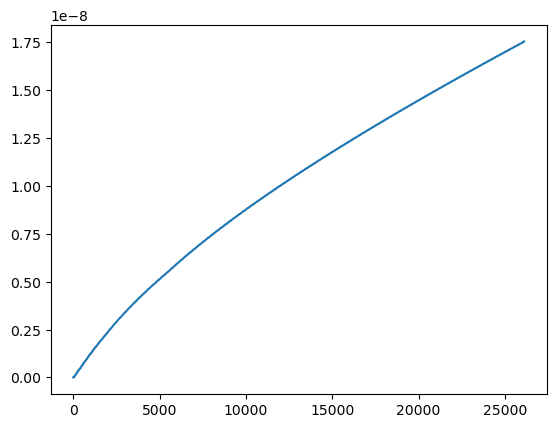

In [28]:
df_characterized.amount.cumsum().plot()